In [1]:
import psycopg2

import random
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader

from Dataset.AutoEncoder_Dataset import AutoEncoder_Dataset
from Model.AutoEncoder import AutoEncoder

from Dataset.LSTM_Dataset import LSTM_Dataset
from Model.LSTM import LSTM

from Dataset.Attention_Dataset import Attention_Dataset
from Model.Attention import LSTMSeq2Seq

SEED = 1234
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

In [2]:
connection_info = "host=localhost dbname=postgres user=postgres password=hd219833 port=5432"
conn = psycopg2.connect(connection_info)
table_1_query = '''
    SELECT * FROM building
    '''
table_2_query = '''
    SELECT * FROM economy
    '''
table_3_query = '''
    SELECT * FROM building_price
    '''
table_1 = pd.read_sql(table_1_query,conn) 
table_2 = pd.read_sql(table_2_query,conn)
table_3 = pd.read_sql(table_3_query,conn) 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [3]:
embedding_lr = 0.01
embedding_batch = 32
embedding_epochs = 50
embedding_dim = 6

lstm_lr = 0.01
lstm_batch = 1
lstm_epochs = 50
hidden_dim = 128
output_dim = 1
window_size = 5

# valid_every = 5
# best_valid_loss = float('inf')

## Embedding

In [15]:
dataset = AutoEncoder_Dataset(table_1, table_2, table_3)
dataloader = DataLoader(dataset, batch_size=embedding_batch)

In [16]:
model = AutoEncoder(embedding_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=embedding_lr)

model.train()
train_losses = []
for epoch in range(embedding_epochs):
    total_train_loss = 0
    for data in dataloader:
        input = data[0]
        target = data[1]
        output = model(input)

        train_loss = criterion(output, target)
        total_train_loss += train_loss.item()

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(dataloader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.4f}')

torch.save(model, f'../데이터/Checkpoint/embedding_lr_{embedding_lr}_batch_{embedding_batch}_epochs_{embedding_epochs}_dim_{embedding_dim}.pth')

Epoch [1/50], Train Loss: 771185011.4903
Epoch [2/50], Train Loss: 658820669.1041
Epoch [3/50], Train Loss: 650684460.1817
Epoch [4/50], Train Loss: 636164024.5267
Epoch [5/50], Train Loss: 624215479.9821
Epoch [6/50], Train Loss: 611366382.7897
Epoch [7/50], Train Loss: 629589433.4562
Epoch [8/50], Train Loss: 612929616.6450
Epoch [9/50], Train Loss: 604105592.7103
Epoch [10/50], Train Loss: 619596761.9125
Epoch [11/50], Train Loss: 600721467.8207
Epoch [12/50], Train Loss: 607814517.3884
Epoch [13/50], Train Loss: 604726882.9491
Epoch [14/50], Train Loss: 599903050.8286
Epoch [15/50], Train Loss: 598806831.6610
Epoch [16/50], Train Loss: 599024814.6947
Epoch [17/50], Train Loss: 595877874.4343
Epoch [18/50], Train Loss: 590941370.1539
Epoch [19/50], Train Loss: 594606762.2793
Epoch [20/50], Train Loss: 594851746.6338
Epoch [21/50], Train Loss: 584602015.4705
Epoch [22/50], Train Loss: 602017384.3833
Epoch [23/50], Train Loss: 596571046.1559
Epoch [24/50], Train Loss: 581024498.6052
E

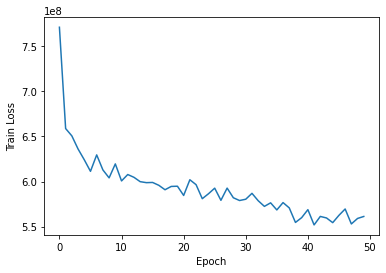

In [17]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.show()

## LSTM

In [18]:
model = torch.load('../데이터/Checkpoint/embedding_lr_0.01_batch_32_epochs_50_dim_6.pth')

dataset = LSTM_Dataset(model, table_1, table_2, table_3, embedding_dim, window_size)
dataloader = DataLoader(dataset, batch_size=lstm_batch)

In [19]:
model = LSTM(embedding_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lstm_lr)

model.train()
for epoch in range(lstm_epochs):
    epoch_loss = 0
    train_num = 1e-9
    for i, batch in enumerate(dataloader):
        src = batch[0].to(DEVICE)
        trg = batch[1].to(DEVICE)
        if(trg != 0):
            train_num += 1
            optimizer.zero_grad()
            output = model(src)
            loss = criterion(output[0], trg)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    train_loss = epoch_loss / train_num
    print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {train_loss:.4f}')

torch.save(model, f'../데이터/Checkpoint/lstm_lsr_{lstm_lr}_batch_{lstm_batch}_epochs_{lstm_epochs}_hdim_{hidden_dim}_odim_{output_dim}_ws{window_size}.pth')

Epoch [1/50], Train Loss: 4457084913.2495
Epoch [2/50], Train Loss: 2639799669.2864
Epoch [3/50], Train Loss: 1889211181.3742
Epoch [4/50], Train Loss: 1621113765.7466
Epoch [5/50], Train Loss: 1536347630.7305
Epoch [6/50], Train Loss: 1508256809.3546
Epoch [7/50], Train Loss: 1501316050.4178
Epoch [8/50], Train Loss: 1496720547.7443
Epoch [9/50], Train Loss: 1493436904.9662
Epoch [10/50], Train Loss: 1491849440.4544
Epoch [11/50], Train Loss: 1490709939.9167
Epoch [12/50], Train Loss: 1490298252.6531
Epoch [13/50], Train Loss: 1490066771.7568
Epoch [14/50], Train Loss: 1489904553.6412
Epoch [15/50], Train Loss: 1489809264.2112
Epoch [16/50], Train Loss: 1489719638.4178
Epoch [17/50], Train Loss: 1489666388.2125
Epoch [18/50], Train Loss: 1489614520.1380
Epoch [19/50], Train Loss: 1489531656.4119
Epoch [20/50], Train Loss: 1489476864.0525
Epoch [21/50], Train Loss: 1489432332.4914
Epoch [22/50], Train Loss: 1489389663.6376
Epoch [23/50], Train Loss: 1489300576.0239
Epoch [24/50], Train

## Attention

In [4]:
model = torch.load('../데이터/Checkpoint/embedding_lr_0.01_batch_32_epochs_50_dim_6.pth')

dataset = Attention_Dataset(model, table_1, table_2, table_3, embedding_dim, window_size)
dataloader = DataLoader(dataset, batch_size=lstm_batch)

In [5]:
for data in dataloader:
    print(data[0].shape)
    print(data[1].shape)
    print(data[2].shape)
    print(data[3].shape)
    break

torch.Size([1, 38, 5, 6])
torch.Size([1])
torch.Size([1, 0])
torch.Size([1, 38, 1])


In [26]:
num = 10
window_size = 5
mx_len = 8
input = torch.randn(num, window_size, embedding_dim)

model = LSTMSeq2Seq(embedding_dim, hidden_dim, output_dim, DEVICE)
model(input,1, mx_len)

tensor([-0.0254], grad_fn=<ViewBackward0>)

In [ ]:
lr = 0.1
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# 학습
history = {'train_loss':[], 'val_loss':[], 'lr':[]}

for epoch in range(N_EPOCHS):
    model.train()
    epoch_loss = 0
    train_num = 1e-9
    for i, batch in enumerate(train_loader):
        src = batch[0].to(DEVICE)
        anw = batch[1]
        max_len = batch[2].to(DEVICE)
        trg = batch[3].to(DEVICE)
        
        for index in anw:
            index.to(DEVICE)
            optimizer.zero_grad()
            output = model(src, index, max_len)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
            
    train_loss = epoch_loss / len(anw)
    train_loss.backward()
    optimizer.step()
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    
    

    if epoch%valid_every==0:
        print("==========================")
        model.eval()
        epoch_loss = 0
        valid_num = 1e-9

        with torch.no_grad():
            for i, batch in enumerate(val_loader):
                src = batch[0].to(DEVICE)
                trg = batch[1].to(DEVICE)
                if(trg != 0):
                    output = model(src, trg)
                    loss = criterion(output, trg)
                    epoch_loss += loss.item()
                    valid_num += 1
        valid_loss = epoch_loss / valid_num
            
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            model.decoder.t=0
            torch.save(model.state_dict(), 'lstm-model.pt')
        print(f'\t Val. Loss: {valid_loss:.3f}')

        history['train_loss'].append(train_loss)
        history['val_loss'].append(valid_loss)
        history['lr'].append(optimizer.param_groups[0]['lr'])

plot_history(history)